<a href="https://colab.research.google.com/github/AnovaYoung/SchoolProjects/blob/main/Anomaly_Detection_with_a_Deep_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "/Users/anovayoungers/Downloads/creditcard.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Normalize the 'Amount' column using StandardScaler
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Drop the 'Time' column as it's not needed for anomaly detection
data = data.drop(['Time'], axis=1)

# Separate features and labels
X = data.drop(['Class'], axis=1)
y = data['Class']

# Display the first few rows of the preprocessed dataset
print(X.head())
print(y.head())



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

The initial preprocessing steps I performed are pretty good, but I do need to address a few more aspects to ensure the data is fully preprocessed for the deep autoencoder.

Specifically:

I need to make sure all features are scaled. (except labels)

Also, I'll Ensure the dataset is balanced since the dataset the way it is, is highly imbalanced.

Ok, I'm going to refine the preprocessing by scaling all the features and then addressing class imbalance using SMOTE.

We are going to start from the beginning.

In [ ]:
from imblearn.over_sampling import SMOTE

file_path = "/Users/anovayoungers/Downloads/creditcard.csv"
data = pd.read_csv(file_path)

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

data = data.drop(['Time'], axis=1)

X = data.drop(['Class'], axis=1)
y = data['Class']

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE to address class-imbalance.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Convert the resampled data back to DataFrame
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Class')

# Display the first few rows of the preprocessed dataset
print(X_resampled.head())
print(y_resampled.head())


         V1        V2        V3        V4        V5        V6        V7  \
0 -0.694242 -0.044075  1.672773  0.973366 -0.245117  0.347068  0.193679   
1  0.608496  0.161176  0.109797  0.316523  0.043483 -0.061820 -0.063700   
2 -0.693500 -0.811578  1.169468  0.268231 -0.364572  1.351454  0.639776   
3 -0.493325 -0.112169  1.182516 -0.609727 -0.007469  0.936150  0.192071   
4 -0.591330  0.531541  1.021412  0.284655 -0.295015  0.071999  0.479302   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.082637  0.331128  0.083386  ...  0.326118 -0.024923  0.382854 -0.176911   
1  0.071253 -0.232494 -0.153350  ... -0.089611 -0.307377 -0.880077  0.162201   
2  0.207373 -1.378675  0.190700  ...  0.680975  0.337632  1.063358  1.456320   
3  0.316018 -1.262503 -0.050468  ... -0.269855 -0.147443  0.007267 -0.304777   
4 -0.226510  0.744326  0.691625  ...  0.529939 -0.012839  1.100011 -0.220123   

        V24       V25       V26       V27       V28    Amount  
0  0

**Now splitting the dataset into training, validation, and testing sets.**

In [ ]:
from sklearn.model_selection import train_test_split

# Training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes
print(f'Training set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')


Training set shape: (341178, 29)
Validation set shape: (113726, 29)
Test set shape: (113726, 29)


**Now I'll be designing and training a deep autoencoder with multiple layers to encode the input data and decode it back to its original form.**

Epoch 1/50
1333/1333 [==============================] - 1s 741us/step - loss: 11.3713 - val_loss: 11.2090
Epoch 2/50
1333/1333 [==============================] - 1s 686us/step - loss: 11.2403 - val_loss: 11.1945
Epoch 3/50
1333/1333 [==============================] - 1s 681us/step - loss: 11.2306 - val_loss: 11.1876
Epoch 4/50
1333/1333 [==============================] - 1s 696us/step - loss: 11.2255 - val_loss: 11.1838
Epoch 5/50
1333/1333 [==============================] - 1s 679us/step - loss: 11.2217 - val_loss: 11.1806
Epoch 6/50
1333/1333 [==============================] - 1s 680us/step - loss: 11.2194 - val_loss: 11.1789
Epoch 7/50
1333/1333 [==============================] - 1s 689us/step - loss: 11.2167 - val_loss: 11.1758
Epoch 8/50
1333/1333 [==============================] - 1s 687us/step - loss: 11.2143 - val_loss: 11.1738
Epoch 9/50
1333/1333 [==============================] - 1s 678us/step - loss: 11.2126 - val_loss: 11.1723
Epoch 10/50
1333/1333 [=======================

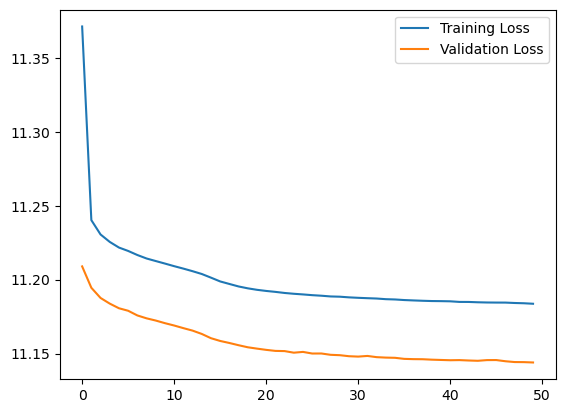

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define a deep autoencoder with an encoder and decoder.
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
encoder = Dense(int(encoding_dim / 4), activation='relu')(encoder)

decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder using the Adam optimizer and mean squared error loss.
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_val, X_val))

# Plot the training and val loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Decreasing Trend: Both the training and validation loss show a decreasing trend over the epochs, this is indicative of the autoencoder learning to better reconstruct the input data.

Validation Loss Lower than Training Loss: In my case, the validation loss is slightly lower than the training loss. This is uncommon but can happen can happen because of noise in the training data or regularization effects, there are a lot of potenital reasons.

Let's modify the autoencoder model to include dropout layers: they can help prevent overfitting by randomly setting a fraction of input units to 0 at each update during training, and batch normalization, which can help stabilize and improve the training process.

Epoch 1/50
1333/1333 [==============================] - 2s 1ms/step - loss: 11.5460 - val_loss: 11.2578
Epoch 2/50
1333/1333 [==============================] - 1s 967us/step - loss: 11.3087 - val_loss: 11.2392
Epoch 3/50
1333/1333 [==============================] - 1s 977us/step - loss: 11.2927 - val_loss: 11.2326
Epoch 4/50
1333/1333 [==============================] - 1s 963us/step - loss: 11.2843 - val_loss: 11.2187
Epoch 5/50
1333/1333 [==============================] - 1s 974us/step - loss: 11.2756 - val_loss: 11.2092
Epoch 6/50
1333/1333 [==============================] - 1s 967us/step - loss: 11.2708 - val_loss: 11.2061
Epoch 7/50
1333/1333 [==============================] - 1s 974us/step - loss: 11.2680 - val_loss: 11.2038
Epoch 8/50
1333/1333 [==============================] - 1s 978us/step - loss: 11.2663 - val_loss: 11.2017
Epoch 9/50
1333/1333 [==============================] - 1s 966us/step - loss: 11.2650 - val_loss: 11.2003
Epoch 10/50
1333/1333 [=========================

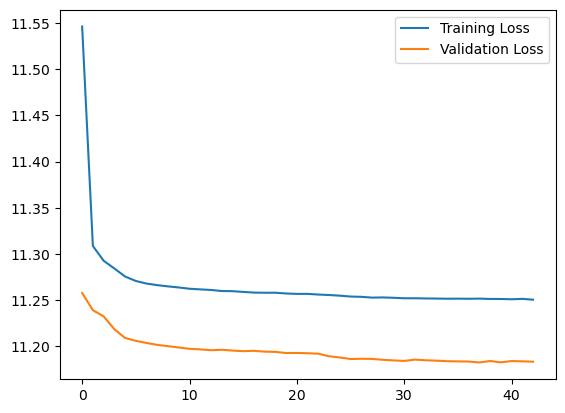

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization

np.random.seed(42)
tf.random.set_seed(42)

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(int(encoding_dim / 4), activation='relu')(encoder)

decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(encoding_dim, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the enhanced autoencoder
history = autoencoder.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_val, X_val),
                        callbacks=[early_stopping])

# Plot the training and val loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Ok, let me try one more time to sharpen the model.

**Last Attempt Model With Additional Layer and Fine-Tuned Hyper-Parameters**

Epoch 1/100
2666/2666 [==============================] - 3s 1ms/step - loss: 11.4385 - val_loss: 11.1478
Epoch 2/100
2666/2666 [==============================] - 3s 960us/step - loss: 11.2166 - val_loss: 11.1381
Epoch 3/100
2666/2666 [==============================] - 3s 962us/step - loss: 11.2111 - val_loss: 11.1405
Epoch 4/100
2666/2666 [==============================] - 3s 958us/step - loss: 11.2075 - val_loss: 11.1351
Epoch 5/100
2666/2666 [==============================] - 3s 956us/step - loss: 11.2074 - val_loss: 11.1395
Epoch 6/100
2666/2666 [==============================] - 3s 954us/step - loss: 11.2072 - val_loss: 11.1356
Epoch 7/100
2666/2666 [==============================] - 3s 956us/step - loss: 11.2068 - val_loss: 11.1314
Epoch 8/100
2666/2666 [==============================] - 3s 959us/step - loss: 11.2052 - val_loss: 11.1314
Epoch 9/100
2666/2666 [==============================] - 3s 954us/step - loss: 11.2054 - val_loss: 11.1361
Epoch 10/100
2666/2666 [===============

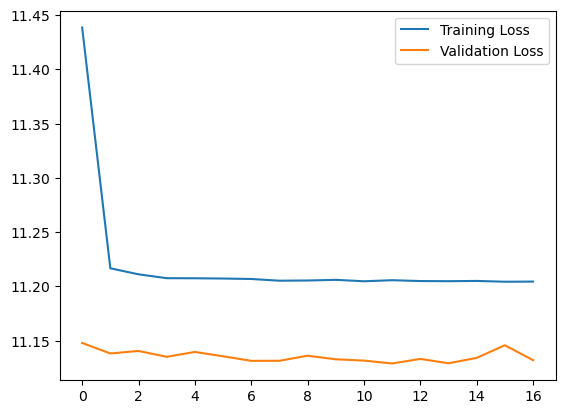

In [ ]:
from tensorflow.keras.regularizers import l2

np.random.seed(42)
tf.random.set_seed(42)

# Define the enhanced deep autoencoder with additional complexity and regularization
input_dim = X_train.shape[1]
encoding_dim = 32  # Increased complexity

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.3)(encoder)
encoder = Dense(int(encoding_dim / 2), activation='relu', kernel_regularizer=l2(0.01))(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.3)(encoder)
encoder = Dense(int(encoding_dim / 4), activation='relu', kernel_regularizer=l2(0.01))(encoder)

decoder = Dense(int(encoding_dim / 2), activation='relu', kernel_regularizer=l2(0.01))(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.3)(decoder)
decoder = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.01))(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.3)(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the enhanced autoencoder
history = autoencoder.fit(X_train, X_train,
                        epochs=100,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(X_val, X_val),
                        callbacks=[early_stopping])

# Same Plot
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Improved Convergence: Both training and validation loss show a consistent decrease and convergence, indicating that the autoencoder is learning effectively. That being said it showed that from the first model.
Validation Loss Lower than Training Loss: The validation loss remains lower than the training loss, which could still be due to regularization effects, noise in the training data, or the nature of the SMOTE resampling, I'm not entirely sure.

**Anomaly Detection**

Now I'm going to use the trained autoencoder to detect anomalies in the test set by comparing the input and output data and calculating reconstruction error.

In [ ]:
import numpy as np

# Use the trained autoencoder to make predictions on the test set
predictions = autoencoder.predict(X_test)

# Calculate the mean squared error (reconstruction error) for each instance in the test set
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Define a threshold to classify an instance as an anomaly
threshold = np.percentile(mse, 95)

# Classify instances as anomalies if their reconstruction error is greater than the given threshold
anomalies = mse > threshold

# Map anomalies to 1 (fraud) and 0 (normal)
y_pred = np.where(anomalies, 1, 0)

# Display the first few predictions
print(y_pred[:100])


3554/3554 [==============================] - 1s 281us/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


**Evaluating the performance of the autoencoder by measuring the accuracy, precision, recall, and F1 score of the anomaly detection.**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.5482
Precision: 0.9967
Recall: 0.0994
F1 Score: 0.1807
Confusion Matrix:
[[56676    19]
 [51363  5668]]


### Analysis of Model Performance

 The accuracy of the model is 54.82%, which indicates that slightly more than half of the transactions were correctly classified as either normal or fraudulent. This is not much better than random guessing. The precision score is exceptionally high at 99.67%, that means that when the model predicts a transaction as fraudulent, it is almost always correct. However, the recall score is significantly low at 9.94%; the model fails to identify a major portion of the actual fraudulent transactions. This low recall results in a truly humbling F1 score of 18.07%, reflecting the trade-off between precision and recall.

The confusion matrix shows the model correctly identified 56,676 genuine transactions and 5,668 fraudulent transactions. However, it incorrectly classified 51,363 genuine transactions as fraudulent and missed 19 actual fraudulent transactions. This is a substantial number of false positives, where normal transactions are incorrectly flagged as fraud.

Overall, while the model excels in precision, its practical utility is massively limited by its low recall. This imbalance meeans the need for a lot more improvements to enhance the model's ability to detect actual fraudulent transactions without significantly increasing the false positive rate. Strategies such as fine-tuning the model, adjusting the anomaly detection threshold, or employing more sophisticated techniques could help achieve a better balance between precision and recall.

**Discuss the Limitations and Potential Applications of Deep Autoencoders for Anomaly Detection**

Limitations:
1. **Imbalance Handling**: The high precision but low recall says that the model is struggling with the imbalanced nature of the dataset. Fraudulent transactions are significantly fewer than genuine ones, and while SMOTE helps it may not fully resolve the issue.
   
2. **Threshold Sensitivity**: The choice of the 95th percentile as the threshold for anomaly detection is somewhat arbitrary and may not be optimal for all datasets including this one. Adjusting this threshold would significantly impact performance metrics.
   
3. **Reconstruction Error**: The autoencoder relies on reconstruction error to detect anomalies. If the fraudulent transactions are not significantly different from the normal transactions in the feature space, the autoencoder would probably fail to detect them.
   
4. **Complexity and Overfitting**: Adding more complexity (layers, neurons, regularization) can help the model learn better but also increases the risk of overfitting, especially with limited data.

5. **Interpretability**: Deep autoencoders, like some select other neural networks, are often considered black-box models. It can be challenging to interpret why certain transactions are classified as anomalies.

Potential Applications:
1. **Credit Card Fraud Detection**: As demonstrated, deep autoencoders can be applied to detect fraudulent transactions. Despite limitations, they can be a part of a broader fraud detection system.
   
2. **Network Intrusion Detection**: Autoencoders can be used to identify unusual patterns in network traffic that may indicate cyber-attacks.
   
3. **Healthcare**: Detecting anomalies in medical records or monitoring data to identify potential health issues or abnormalities.
   
4. **Manufacturing**: Monitoring sensor data from machinery to detect early signs of equipment failure or production defects.
   

**Conclusion:**
Deep autoencoders are a great approach to anomaly detection, particularly in scenarios where the normal pattern significantly outnumbers anomalies. However, their effectiveness can be limited by data imbalance and the nature of anomalies. Continuous model tuning, hybrid approaches combining multiple detection techniques, and incorporating domain-specific knowledge can enhance their performance and applicability.
